## **Indian Dance Form Classification**

### The dataset consists of 599 images belonging to 8 categories, namely manipuri, bharatanatyam, odissi, kathakali, kathak, sattriya, kuchipudi, and mohiniyattam.

### **Import Essential Libraries**

In [21]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

### **Define Dataset Path**

In [11]:
TRAIN_PATH = "dataset/train"
TEST_PATH = "dataset/test"

### **Function to Show Some Dance Images**

In [12]:
def load_dance_img(path):
    dance_image = cv2.imread(path)
    dance_image = cv2.resize(dance_image, (224, 224))
    return dance_image[..., ::-1]

### Kathak

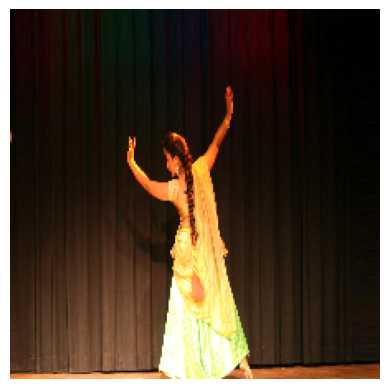

In [13]:
kathak_images = os.listdir(os.path.join(TRAIN_PATH, "kathak"))

image_path = os.path.join(TRAIN_PATH, "kathak", kathak_images[7])

plt.imshow(load_dance_img(image_path))
plt.axis("off")
plt.show()

### Kathakali

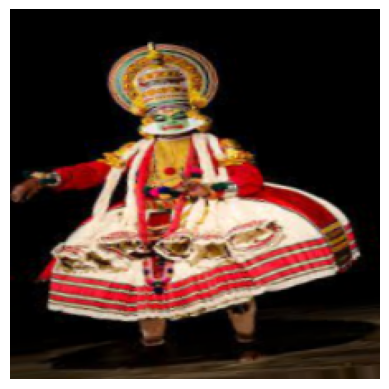

In [14]:
kathakali_images = os.listdir(os.path.join(TRAIN_PATH, "kathakali"))

image_path = os.path.join(TRAIN_PATH, "kathakali", kathakali_images[7])

plt.imshow(load_dance_img(image_path))
plt.axis("off")
plt.show()

### Manipuri

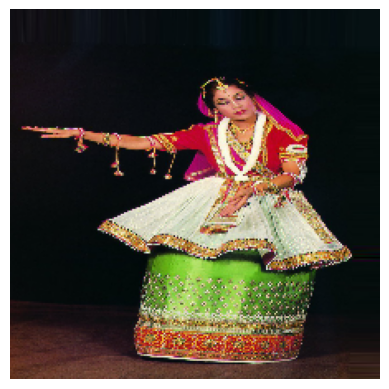

In [15]:
manipuri_images = os.listdir(os.path.join(TRAIN_PATH, "manipuri"))

image_path = os.path.join(TRAIN_PATH, "manipuri", manipuri_images[7])

plt.imshow(load_dance_img(image_path))
plt.axis("off")
plt.show()

### **Split & Train the Dataset**

Total Images: 599
Classes: ['bharatanatyam' 'kathak' 'kathakali' 'kuchipudi' 'manipuri'
 'mohiniyattam' 'odissi' 'sattriya']
Training Samples: 479
Validation Samples: 120


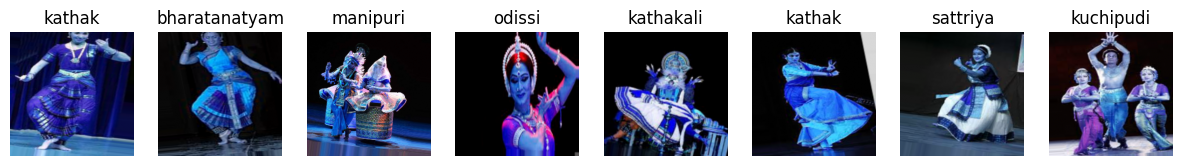

In [16]:
images = []
labels = []

for dance_form in os.listdir(TRAIN_PATH):
    class_path = os.path.join(TRAIN_PATH, dance_form)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                image = image / 255.0 
                images.append(image)
                labels.append(dance_form)

images = np.array(images)
labels = np.array(labels)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

labels_one_hot = to_categorical(labels_encoded)

X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

print(f"Total Images: {len(images)}")
print(f"Classes: {label_encoder.classes_}")
print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(label_encoder.inverse_transform([np.argmax(y_train[i])])[0])
    ax.axis("off")
plt.show()

### **Models Construction**

### **Common Structure**

In [17]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8

### **1. VGG16**

Found 482 images belonging to 8 classes.
Found 117 images belonging to 8 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                             

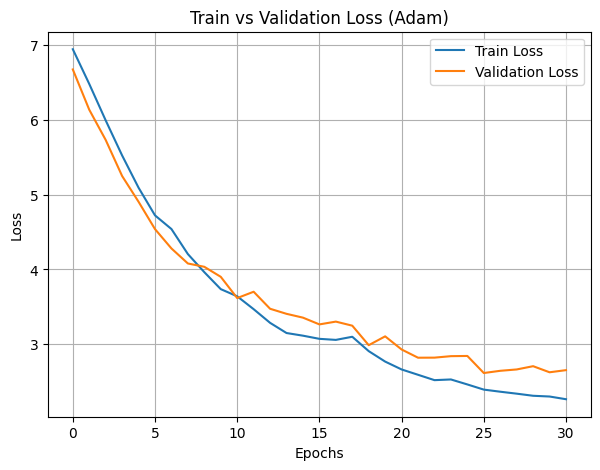

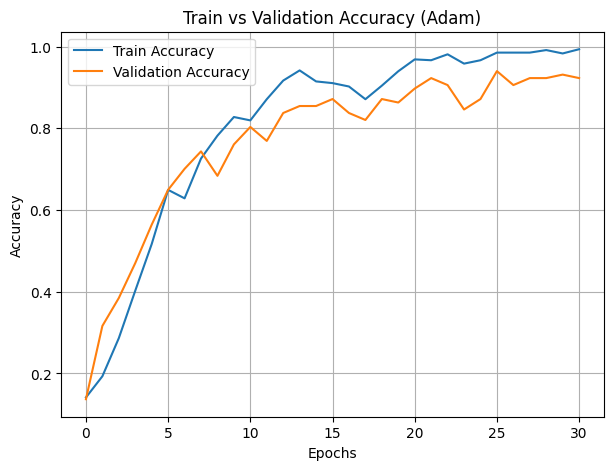

In [ ]:
train_datagen_vgg16 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_generator_vgg16 = train_datagen_vgg16.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training"
)

val_generator_vgg16 = train_datagen_vgg16.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation"
)

base_model_vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model_vgg16.layers:
    layer.trainable = False

for layer in base_model_vgg16.layers[-4:]:
    layer.trainable = True

x_vgg16 = GlobalAveragePooling2D()(base_model_vgg16.output)
x_vgg16 = Dense(4096, activation='relu', name='fc1', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_vgg16)
x_vgg16 = Dropout(0.5)(x_vgg16)
x_vgg16 = Dense(4096, activation='relu', name='fc2', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_vgg16)
x_vgg16 = Dropout(0.5)(x_vgg16)

output_layer_vgg16 = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x_vgg16)

dance_model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=output_layer_vgg16)
dance_model_vgg16.summary()

dance_model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

early_stopping_vgg16 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_vgg16 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_vgg16 = dance_model_vgg16.fit(train_generator_vgg16,
                          validation_data=val_generator_vgg16,
                          epochs=50,
                          callbacks=[early_stopping_vgg16, reduce_lr_vgg16])

dance_model_vgg16.save("models/dance_model_vgg16.h5")

epochs_range_vgg16 = range(len(history_vgg16.history['loss']))

plt.figure(figsize=(7, 5))
plt.plot(epochs_range_vgg16, history_vgg16.history['loss'], label='Train Loss')
plt.plot(epochs_range_vgg16, history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs_range_vgg16, history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range_vgg16, history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **2. VGG19**

Found 482 images belonging to 8 classes.
Found 117 images belonging to 8 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                           

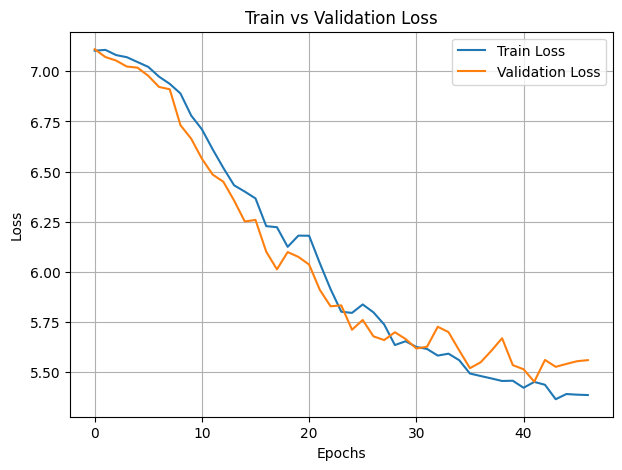

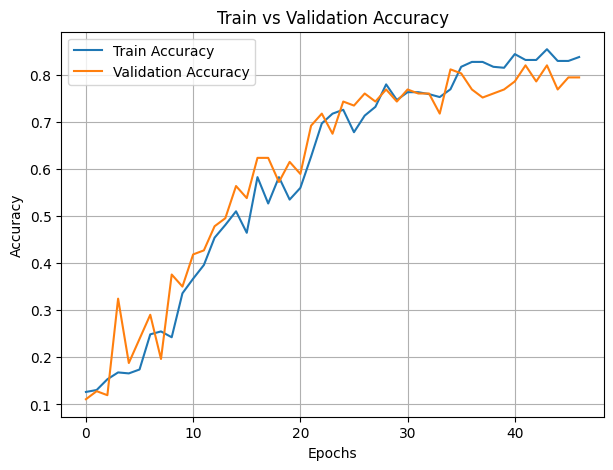

In [19]:
train_datagen_vgg19 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_generator_vgg19 = train_datagen_vgg19.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training"
)

val_generator_vgg19 = train_datagen_vgg19.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation"
)

base_model_vgg19 = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model_vgg19.layers:
    layer.trainable = False

for layer in base_model_vgg19.layers[-4:]:
    layer.trainable = True

x_vgg19 = GlobalAveragePooling2D()(base_model_vgg19.output)
x_vgg19 = Dense(4096, activation='relu', name='fc1', kernel_regularizer=l2(0.001))(x_vgg19)
x_vgg19 = Dropout(0.4)(x_vgg19)
x_vgg19 = Dense(4096, activation='relu', name='fc2', kernel_regularizer=l2(0.001))(x_vgg19)
x_vgg19 = Dropout(0.4)(x_vgg19)

output_layer_vgg19 = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x_vgg19)

dance_model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=output_layer_vgg19)
dance_model_vgg19.summary()

dance_model_vgg19.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_vgg19 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_vgg19 = dance_model_vgg19.fit(train_generator_vgg19,
                          validation_data=val_generator_vgg19,
                          epochs=50,
                          callbacks=[early_stopping_vgg19, reduce_lr_vgg19])

dance_model_vgg19.save("models/dance_model_vgg19.h5")

epochs_range_vgg19 = range(len(history_vgg19.history['loss']))

plt.figure(figsize=(7, 5))
plt.plot(epochs_range_vgg19, history_vgg19.history['loss'], label='Train Loss')
plt.plot(epochs_range_vgg19, history_vgg19.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs_range_vgg19, history_vgg19.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range_vgg19, history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **3. MobileNetV2**

Found 482 images belonging to 8 classes.
Found 117 images belonging to 8 classes.
Epoch 1/50
16/16 [==============================] - 12s 622ms/step - loss: 2.4612 - accuracy: 0.2573 - val_loss: 1.4294 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 9s 542ms/step - loss: 1.4865 - accuracy: 0.4876 - val_loss: 1.1382 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 9s 525ms/step - loss: 1.0841 - accuracy: 0.6017 - val_loss: 0.8717 - val_accuracy: 0.7265 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 8s 531ms/step - loss: 0.9824 - accuracy: 0.6618 - val_loss: 0.7334 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 9s 539ms/step - loss: 0.8107 - accuracy: 0.7178 - val_loss: 0.7109 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 8s 527ms/step - loss: 0.7205 - accuracy: 0.7656 - val_loss: 0.7157 - val_accuracy: 0.7436 

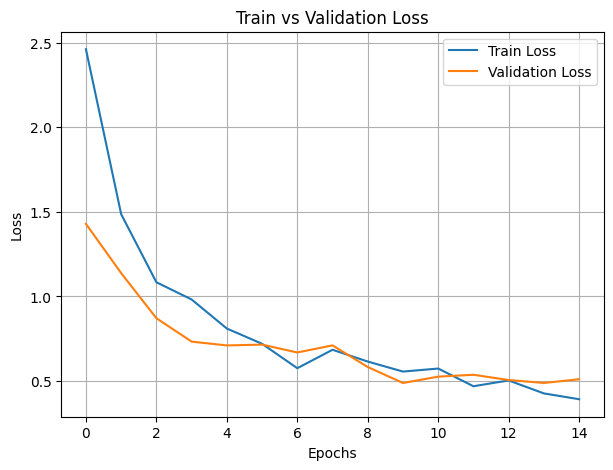

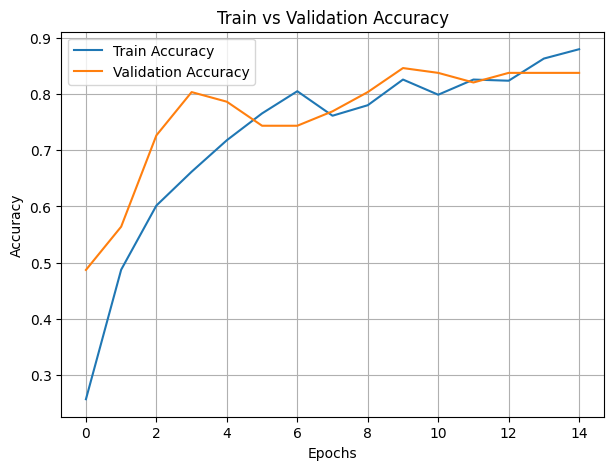

In [20]:
train_datagen_mobnetv2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,      
    brightness_range=[0.8, 1.2], 
    validation_split=0.2       
)

train_gen_mobnetv2 = train_datagen_mobnetv2.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen_mobnetv2 = train_datagen_mobnetv2.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

base_model_mobnetv2 = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model_mobnetv2.trainable = False

x_mobnetv2 = GlobalAveragePooling2D()(base_model_mobnetv2.output)
x_mobnetv2 = Dense(512, activation='relu', name='fc1')(x_mobnetv2)
x_mobnetv2 = Dropout(0.5)(x_mobnetv2)
x_mobnetv2 = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x_mobnetv2)

model_mobnetv2 = Model(inputs=base_model_mobnetv2.input, outputs=x_mobnetv2)

model_mobnetv2.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

early_stopping_mobnetv2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_mobnetv2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_mobnetv2 = model_mobnetv2.fit(train_gen_mobnetv2,
                    validation_data=val_gen_mobnetv2,
                    epochs=50,
                    callbacks=[early_stopping_mobnetv2, reduce_lr_mobnetv2])

model_mobnetv2.save("models/dance_model_mobilenetv2.h5")

epochs_range_mobnetv2 = range(len(history_mobnetv2.history['loss']))

plt.figure(figsize=(7, 5))
plt.plot(epochs_range_mobnetv2, history_mobnetv2.history['loss'], label='Train Loss')
plt.plot(epochs_range_mobnetv2, history_mobnetv2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs_range_mobnetv2, history_mobnetv2.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range_mobnetv2, history_mobnetv2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **Model Accuracy & Loss Comparison**

In [22]:
vgg16_train_acc = history_vgg16.history['accuracy'][-1]
vgg16_val_acc = history_vgg16.history['val_accuracy'][-1]
vgg16_train_loss = history_vgg16.history['loss'][-1]
vgg16_val_loss = history_vgg16.history['val_loss'][-1]

vgg19_train_acc = history_vgg19.history['accuracy'][-1]
vgg19_val_acc = history_vgg19.history['val_accuracy'][-1]
vgg19_train_loss = history_vgg19.history['loss'][-1]
vgg19_val_loss = history_vgg19.history['val_loss'][-1]

mobnetv2_train_acc = history_mobnetv2.history['accuracy'][-1]
mobnetv2_val_acc = history_mobnetv2.history['val_accuracy'][-1]
mobnetv2_train_loss = history_mobnetv2.history['loss'][-1]
mobnetv2_val_loss = history_mobnetv2.history['val_loss'][-1]

print("VGG16 - Train Acc:", vgg16_train_acc, "Val Acc:", vgg16_val_acc, "Train Loss:", vgg16_train_loss, "Val Loss:", vgg16_val_loss)
print("VGG19 - Train Acc:", vgg19_train_acc, "Val Acc:", vgg19_val_acc, "Train Loss:", vgg19_train_loss, "Val Loss:", vgg19_val_loss)
print("MobileNetV2 - Train Acc:", mobnetv2_train_acc, "Val Acc:", mobnetv2_val_acc, "Train Loss:", mobnetv2_train_loss, "Val Loss:", mobnetv2_val_loss)

VGG16 - Train Acc: 0.9937759041786194 Val Acc: 0.9230769276618958 Train Loss: 2.264345645904541 Val Loss: 2.6532342433929443
VGG19 - Train Acc: 0.8381742835044861 Val Acc: 0.7948718070983887 Train Loss: 5.385707378387451 Val Loss: 5.559832572937012
MobileNetV2 - Train Acc: 0.8796680569648743 Val Acc: 0.8376068472862244 Train Loss: 0.3929908573627472 Val Loss: 0.5110588669776917


### **Model Loss & Accuracy Comparison Graph**

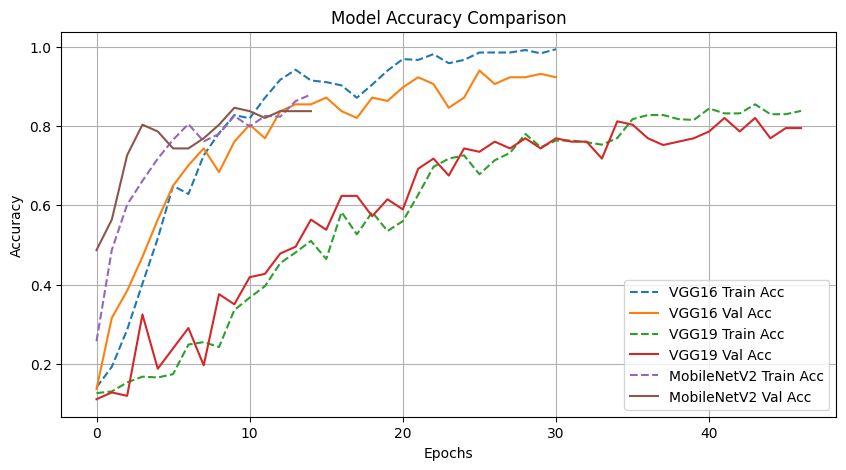

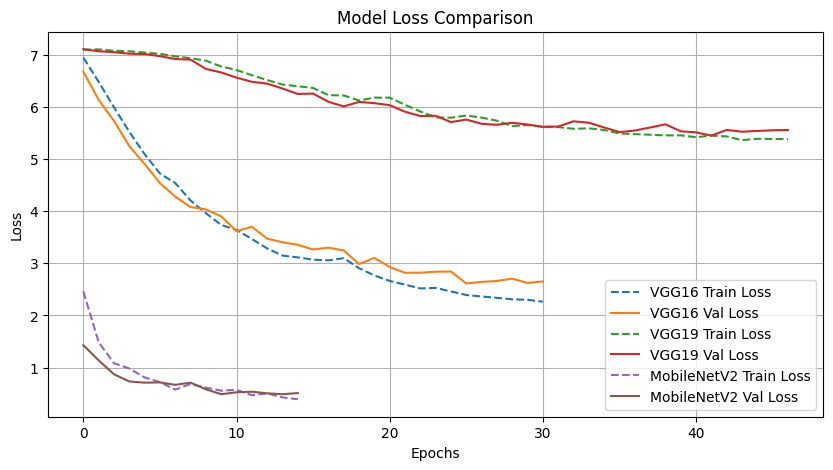

In [23]:
epochs_vgg16 = range(len(history_vgg16.history['loss']))
epochs_vgg19 = range(len(history_vgg19.history['loss']))
epochs_mobnetv2 = range(len(history_mobnetv2.history['loss']))

plt.figure(figsize=(10, 5))
plt.plot(epochs_vgg16, history_vgg16.history['accuracy'], label='VGG16 Train Acc', linestyle='dashed')
plt.plot(epochs_vgg16, history_vgg16.history['val_accuracy'], label='VGG16 Val Acc')

plt.plot(epochs_vgg19, history_vgg19.history['accuracy'], label='VGG19 Train Acc', linestyle='dashed')
plt.plot(epochs_vgg19, history_vgg19.history['val_accuracy'], label='VGG19 Val Acc')

plt.plot(epochs_mobnetv2, history_mobnetv2.history['accuracy'], label='MobileNetV2 Train Acc', linestyle='dashed')
plt.plot(epochs_mobnetv2, history_mobnetv2.history['val_accuracy'], label='MobileNetV2 Val Acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_vgg16, history_vgg16.history['loss'], label='VGG16 Train Loss', linestyle='dashed')
plt.plot(epochs_vgg16, history_vgg16.history['val_loss'], label='VGG16 Val Loss')

plt.plot(epochs_vgg19, history_vgg19.history['loss'], label='VGG19 Train Loss', linestyle='dashed')
plt.plot(epochs_vgg19, history_vgg19.history['val_loss'], label='VGG19 Val Loss')

plt.plot(epochs_mobnetv2, history_mobnetv2.history['loss'], label='MobileNetV2 Train Loss', linestyle='dashed')
plt.plot(epochs_mobnetv2, history_mobnetv2.history['val_loss'], label='MobileNetV2 Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

### **Save The Best Model**

In [24]:
best_model_name = "VGG16"
best_model_acc = vgg16_val_acc
best_model_path = "models/dance_model_vgg16.h5"

if vgg19_val_acc > best_model_acc:
    best_model_name = "VGG19"
    best_model_acc = vgg19_val_acc
    best_model_path = "models/dance_model_vgg19.h5"

if mobnetv2_val_acc > best_model_acc:
    best_model_name = "MobileNetV2"
    best_model_acc = mobnetv2_val_acc
    best_model_path = "models/dance_model_mobilenetv2.h5"

print("Best Model:", best_model_name, "with Validation Accuracy:", best_model_acc)

shutil.copy(best_model_path, "models/best_model.h5")
print("Best model saved as 'best_model.h5'")

Best Model: VGG16 with Validation Accuracy: 0.9230769276618958
Best model saved as 'best_model.h5'


### **THANK YOU**